In [1]:
%load_ext blackcellmagic

In [2]:
import pandas as pd
import re
import numpy as np
import random

import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import pymorphy2
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn import metrics
from math import log
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly

import itertools

In [3]:
data = pd.read_csv('SMSSpamCollection.csv', sep='\t', header=None)
print(data.shape)

(5572, 2)


### Preprocessing data

In [4]:
morph = pymorphy2.MorphAnalyzer()
stop_words = stopwords.words("english")


def process_text(text):
    min_length = 3
    lower = (word.lower() for word in nltk.wordpunct_tokenize(text))
    pattern = re.compile("[a-z]+")
    words = pattern.findall(" ".join(lower))
    norm_form = (morph.parse(word)[0].normal_form for word in words)
    tokens = [word for word in norm_form if word not in stop_words]
    return " ".join(tokens)

In [5]:
data["text"] = data[1].map(process_text)
data = data.rename(columns={0: "flag"})
data = data.drop([1], axis=1)
data.to_csv("temp_spam.csv", index=False)
data.groupby("flag").describe()

text                                                               
     count unique                                                top freq
flag                                                                     
ham   4825   4478                                   sorry call later   30
spam   747    580  private account statement shows un redeemed po...    9

In [6]:
df = pd.read_csv("temp_spam.csv").dropna()
df[["flag", "text"]].groupby(["flag"]).count()

,text
flag,
ham,4817
spam,747


In [7]:
labels = ["ham", "spam"]
values = [4822, 747]

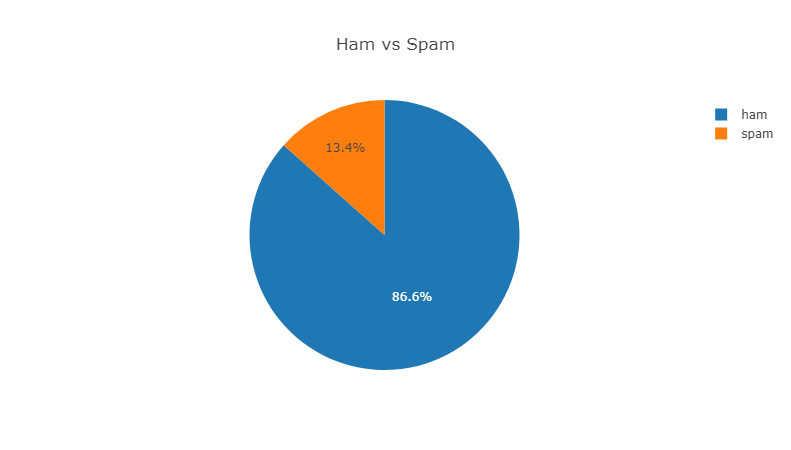

In [8]:
plotly.offline.init_notebook_mode(connected=True)
iplot(
    {
        "data": [go.Pie(labels=labels, values=values)],
        "layout": go.Layout(title="Ham vs Spam"),
    },
    filename="pie.html",
)

## Sklearn NaiveBayes

In [9]:
tf_idf = CountVectorizer()
clf = MultinomialNB()
X = tf_idf.fit_transform(data["text"]).toarray()
y = data["flag"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [10]:
def plot_confusion_matrix(cm, classes,               
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):

    plt.figure(figsize=(20,10))
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
      
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, 
                 '%.2f%%' %  cm[i, j],
                 horizontalalignment='center',
                 color='black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<Figure size 1440x720 with 0 Axes>

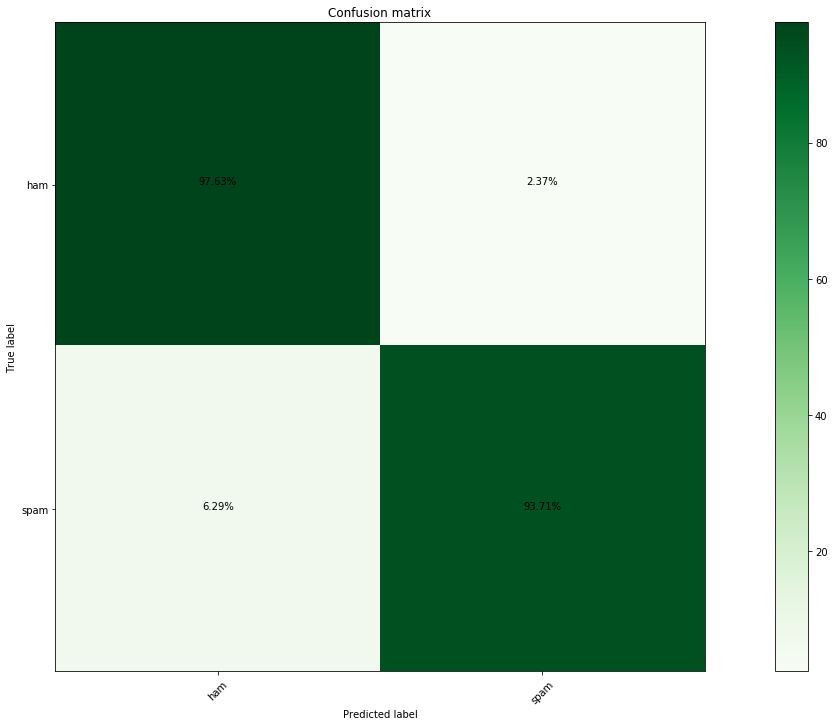

In [11]:
score = metrics.f1_score(y_test, pred, average="micro")
authors = list(set(y_train))
cm = metrics.confusion_matrix(y_test, pred, labels=authors)
plt.figure(figsize=(20, 10))
plot_confusion_matrix(cm, authors)

### F1 cross_val_score

In [12]:
kf = KFold(n_splits=5)
cross_val_score(clf, X, y, scoring="f1_micro", cv=kf).mean()

0.9768477832076063

### My NaiveBayes

In [13]:
morph = pymorphy2.MorphAnalyzer()
stop_words = stopwords.words("english")


def process_text(text):
    min_length = 3
    lower = (word.lower() for word in nltk.wordpunct_tokenize(text))
    pattern = re.compile("[a-z]+")
    words = pattern.findall(" ".join(lower))
    norm_form = (morph.parse(word)[0].normal_form for word in words)
    tokens = [word for word in norm_form if word not in stop_words]
    return tokens

In [14]:
class NaiveBayes(object):
    def __init__(self, Train):
        self.mails, self.labels = Train["message"], Train["labels"]

    def train(self):
        self.calc_TF_and_IDF()
        self.calc_TF_IDF()

    def calc_TF_and_IDF(self):
        noOfMessages = self.mails.shape[0]
        self.spam_mails, self.ham_mails = (
            self.labels.value_counts()[1],
            self.labels.value_counts()[0],
        )
        self.total_mails = self.spam_mails + self.ham_mails
        self.spam_words = 0
        self.ham_words = 0
        self.tf_spam = dict()
        self.tf_ham = dict()
        self.idf_spam = dict()
        self.idf_ham = dict()
        for i in range(noOfMessages):
            message_processed = process_text(self.mails[i])
            count = (
                list()
            )  # To keep track of whether the word has ocured in the message or not.
            # For IDF
            for word in message_processed:
                if self.labels[i]:
                    self.tf_spam[word] = self.tf_spam.get(word, 0) + 1
                    self.spam_words += 1
                else:
                    self.tf_ham[word] = self.tf_ham.get(word, 0) + 1
                    self.ham_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels[i]:
                    self.idf_spam[word] = self.idf_spam.get(word, 0) + 1
                else:
                    self.idf_ham[word] = self.idf_ham.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        self.sum_tf_idf_spam = 0
        self.sum_tf_idf_ham = 0
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word]) * log(
                (self.spam_mails + self.ham_mails)
                / (self.idf_spam[word] + self.idf_ham.get(word, 0))
            )
            self.sum_tf_idf_spam += self.prob_spam[word]
        for word in self.tf_spam:
            self.prob_spam[word] = (self.prob_spam[word] + 1) / (
                self.sum_tf_idf_spam + len(list(self.prob_spam.keys()))
            )

        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word]) * log(
                (self.spam_mails + self.ham_mails)
                / (self.idf_spam.get(word, 0) + self.idf_ham[word])
            )
            self.sum_tf_idf_ham += self.prob_ham[word]
        for word in self.tf_ham:
            self.prob_ham[word] = (self.prob_ham[word] + 1) / (
                self.sum_tf_idf_ham + len(list(self.prob_ham.keys()))
            )

        self.prob_spam_mail, self.prob_ham_mail = (
            self.spam_mails / self.total_mails,
            self.ham_mails / self.total_mails,
        )

    def classify(self, process_text):
        pSpam, pHam = 0, 0
        for word in process_text:
            if word in self.prob_spam:
                pSpam += log(self.prob_spam[word])
            else:
                pSpam -= log(self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
            if word in self.prob_ham:
                pHam += log(self.prob_ham[word])
            else:
                pHam -= log(self.sum_tf_idf_ham + len(list(self.prob_ham.keys())))
            pSpam += log(self.prob_spam_mail)
            pHam += log(self.prob_ham_mail)
        return pSpam >= pHam

    def predict(self, Test):
        result = dict()
        for (i, message) in enumerate(Test):
            processed_message = process_text(message)
            result[i] = int(self.classify(processed_message))
        return result

In [15]:
data = pd.read_csv("SMSSpamCollection.csv", sep="\t", header=None)
data.rename(columns={0: "labels", 1: "message"}, inplace=True)
data["labels"] = data["labels"].map({"ham": 0, "spam": 1})
data.head()

,labels,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


train_test_split

In [16]:
train_size = round(5572 * 0.8)

In [17]:
ind = list(range(5572))
random.shuffle(ind)

In [18]:
train_ind = ind[:train_size]
test_ind = ind[train_size:]
Train = data.loc[train_ind]
Test = data.loc[test_ind]

In [19]:
Train.reset_index(inplace = True)
Train.drop(['index'], axis = 1, inplace = True)
Train.head()

,labels,message
0,0,I wanted to wish you a Happy New Year and I wa...
1,0,Just trying to figure out when I'm suppose to ...
2,0,WHAT TIME U WRKIN?
3,0,So how's the weather over there?
4,0,I'll talk to the others and probably just come...


In [20]:
Test.reset_index(inplace = True)
Test.drop(['index'], axis = 1, inplace = True)
Test.head()

,labels,message
0,0,Hey doc pls I want to get nice t shirt for my ...
1,0,But if she.s drinkin i'm ok.
2,0,"LOOK AT AMY URE A BEAUTIFUL, INTELLIGENT WOMAN..."
3,0,I'm turning off my phone. My moms telling ever...
4,0,"Sir, i am waiting for your call, once free ple..."


In [21]:
Train['labels'].value_counts()

0    3868
1     590
Name: labels, dtype: int64

In [22]:
Test['labels'].value_counts()

0    957
1    157
Name: labels, dtype: int64

In [23]:
y_test_2 = Test['labels']

classification

In [24]:
clf1 = NaiveBayes(Train)
clf1.train()
pred_2 = pd.Series(list(clf1.predict(Test["message"]).values()))

In [25]:
y_test_2 = y_test_2.map({0 : 'ham', 1 : 'spam'})

In [26]:
pred_2 = pred_2.map({0 : 'ham', 1 : 'spam'})

<Figure size 1440x720 with 0 Axes>

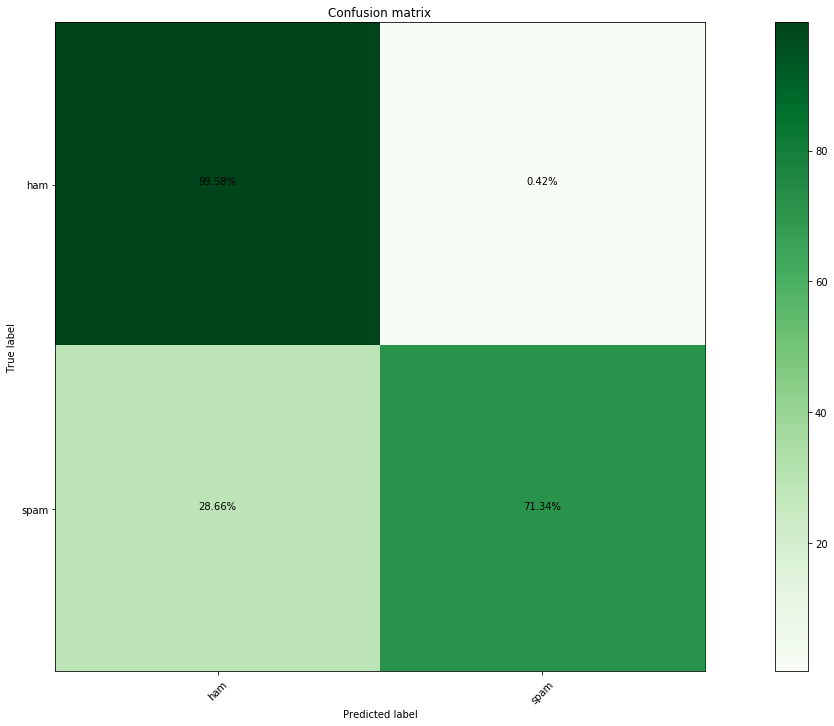

In [27]:
score = metrics.f1_score(y_test_2, pred_2, average="micro")
authors = list(set(y_test_2))
cm = metrics.confusion_matrix(y_test_2, pred_2, labels=authors)
plt.figure(figsize=(20, 10))
plot_confusion_matrix(cm, authors)

### F1_score

In [28]:
score = metrics.f1_score(y_test_2, pred_2, average="micro")
score

0.9560143626570916

### KFold F1_score

In [29]:
kf = KFold(n_splits=5)
for train_ind, test_ind in kf.split(data):
    train_ind, test_ind = list(train_ind), list(test_ind)
    Train = data.loc[train_ind]
    Train.reset_index(inplace=True)
    Train.drop(["index"], axis=1, inplace=True)
    Test = data.loc[test_ind]
    Test.reset_index(inplace=True)
    Test.drop(["index"], axis=1, inplace=True)
    clf1 = NaiveBayes(Train)
    clf1.train()
    result = pd.Series(list(clf1.predict(Test["message"]).values()))
    print("F1-score:", metrics.f1_score(Test["labels"], result, average="micro"))

F1-score: 0.9542600896860987
F1-score: 0.9560538116591928
F1-score: 0.9605026929982047
F1-score: 0.952423698384201
F1-score: 0.9569120287253142


### KFold F1_score for NB from Sklearn

In [30]:
cross_val_score(clf, X, y, scoring="f1_micro", cv=kf)

array([0.97488789, 0.98295964, 0.97486535, 0.97307002, 0.97845601])